## Facial keypoint vizualization

In [ ]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

key_pts_frame = pd.read_csv('../input/facialkeypoint/training_frames_keypoints.csv')

n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))


# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]
Number of images:  3462


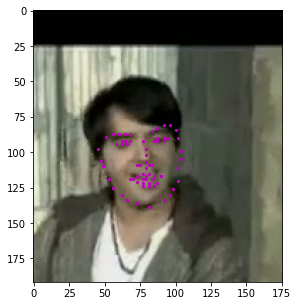

In [ ]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')
    
# Display a few different types of images by changing the index n

# select an image by index in our data frame
n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
image = mpimg.imread(os.path.join('../input/facialkeypoint/training/', image_name))
show_keypoints(image, key_pts)
plt.show()

In [ ]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].to_numpy()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

Length of dataset:  3462
0 (231, 205, 3) (68, 2)
1 (306, 287, 3) (68, 2)
2 (153, 168, 3) (68, 2)


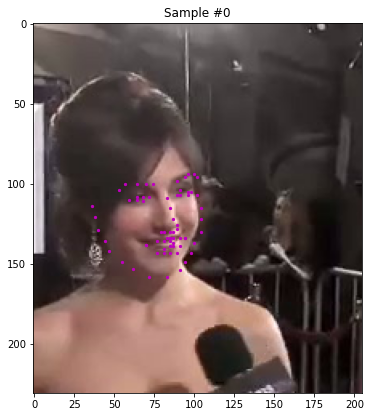

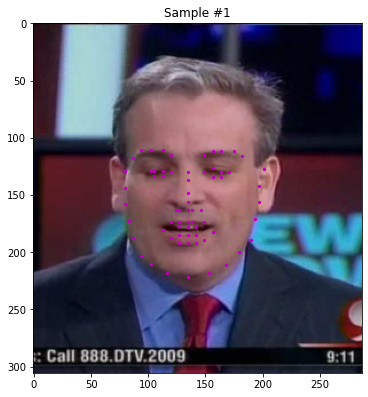

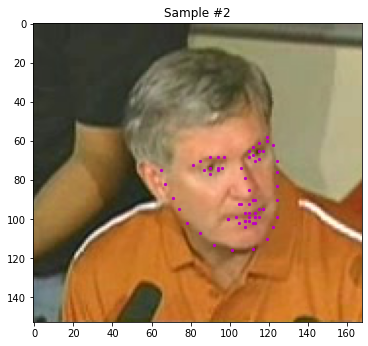

In [ ]:

# Construct the dataset
face_dataset = FacialKeypointsDataset(csv_file='../input/facialkeypoint/training_frames_keypoints.csv',
                                      root_dir='../input/facialkeypoint/training/')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

# Display a few of the images from the dataset
num_to_display = 3

for i in range(num_to_display):
    
    # define the size of images
    fig = plt.figure(figsize=(20,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    # Using the same display function, defined earlier
    show_keypoints(sample['image'], sample['keypoints'])

## Define the image transforms

In [ ]:
import torch
from torchvision import transforms, utils
# tranforms
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        #image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy = np.copy(image)
        image_copy = image_copy / 255.0
        image_copy= ( image_copy-mean ) /std
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}
    


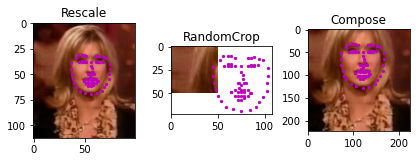

In [ ]:
# test out some of these transforms
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
test_num = 500
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

In [ ]:
# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='../input/facialkeypoint/training_frames_keypoints.csv',
                                             root_dir='../input/facialkeypoint/training/',
                                             transform=data_transform)

# print some stats about the transformed data
print('Number of images: ', len(transformed_dataset))

# make sure the sample tensors are the expected size
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])
4 torch.Size([3, 224, 224]) torch.Size([68, 2])


## Model Architectuers

# 1.Custom Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FacialKeyNet(nn.Module):
    def __init__(self , in_channel , out_channel , seed):
        super(FacialKeyNet , self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.seed = torch.manual_seed(seed)
        
        self.conv_1 = FacialKeyNet.__conv_block( in_size = 3 , out_size = 32 )   # 1- 224 - 224 --> 32 - 224 - 224
        self.conv_2 = FacialKeyNet.__conv_block( in_size = 32 , out_size = 64  , maxpool=True ) # 32 - 224 - 224 --> 64 - 112 - 112
        #self.conv_3 = FacialKeyNet.__conv_block( in_size = 64 , out_size = 64  , maxpool=True ) 
        self.conv_4 = FacialKeyNet.__conv_block( in_size = 64 , out_size = 128 , maxpool=True ) # 64 - 112 - 112 --> 128 - 56 - 56 
        #self.conv_5 = FacialKeyNet.__conv_block( in_size = 128 , out_size = 128 , maxpool=True )
        self.conv_6 = FacialKeyNet.__conv_block( in_size = 128 , out_size = 256 , maxpool=True) # 128 - 56 - 56 --> 256 - 28 - 28
        #self.conv_7 = FacialKeyNet.__conv_block( in_size = 256 , out_size = 256 , maxpool=True ) # 256 - 28 - 28 --> 512 - 14 - 14
        #self.conv_8 = FacialKeyNet.__conv_block( in_size = 256 , out_size = 512 , maxpool=False )
        #self.conv_9 = FacialKeyNet.__conv_block( in_size = 512 , out_size = 512 , maxpool=True )
        #self.conv_10 = FacialKeyNet.__conv_block(in_size = 512 , out_size = 1024 , maxpool=True ) # 512 - 14 - 14  --> 1024 - 7 - 7
        self.flatten_size = 256 * 28 * 28
        self.fc_1 = nn.Linear(self.flatten_size , self.out_channel)
        #self.fc_bn1 = nn.BatchNorm1d(1024)
        #self.fc_2 = nn.Linear(1024 , self.out_channel )
        self.tanh = nn.Tanh()
        
    def forward(self , x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        #x = self.conv_3(x)
        x = self.conv_4(x)
        #x = self.conv_5(x)
        x = self.conv_6(x)
        #x = self.conv_7(x)
        #x = self.conv_8(x)
        #x = self.conv_9(x)
        #x = self.conv_10(x)
        x = x.view(-1 , self.flatten_size)
        #x = F.dropout(F.relu(self.fc_bn1(self.fc_1(x))) , 0.5)
        x = self.fc_1(x)
        
        return x
        
        
    @staticmethod
    def __conv_block( in_size , out_size , kernel_size = 3 ,
                     strides = 1 , batch_norm=True , maxpool=False , dropout = 0.3 , drop_in=False):
        layers =[]
        conv_2d = nn.Conv2d(in_channels=in_size , out_channels=out_size , kernel_size=kernel_size ,
                            stride=strides , padding=1 , bias=True)
        layers.append(conv_2d)
        if(batch_norm):
            bn = nn.BatchNorm2d(out_size)
            layers.append(bn)
            
        activ = nn.LeakyReLU(negative_slope=0.2)
        layers.append(activ)
        
        if(maxpool):
            m_pool = nn.MaxPool2d(kernel_size=2 , stride=2)
            layers.append(m_pool)
        if (drop_in):  
            drop_layer = nn.Dropout2d(p=dropout)
            layers.append(drop_layer)

        return nn.Sequential(*layers)      
    

# 2. Vgg19 Model

In [ ]:
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F

class VggFacialNet(nn.Module):
    def __init__(self , in_channel , out_channel , seed):
        super(VggFacialNet , self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.seed = seed

        self.vgg_19 = models.vgg19_bn(pretrained=True, progress=True)
        
        self.vgg_19.classifier = nn.Sequential(
            nn.Linear(in_features=25088 , out_features=self.out_channel , bias=True) 
        )
        
    def forward(self , x ):
        
        x = self.vgg_19(x)
        
        return x

In [ ]:
facial_net = VggFacialNet(in_channel=3 , out_channel=68*2 , seed=1444)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth


In [ ]:
facial_net.load_state_dict(torch.load("../input/facialnetmodels/facial_vggnet.pth"))

<All keys matched successfully>

# 3. ResNet Model

In [ ]:
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNetFacialNet(nn.Module):
    def __init__(self , in_channel , out_channel , seed):
        super(ResNetFacialNet , self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.seed = seed

        self.resnet_101 = models.resnet101(pretrained=True, progress=True)
        
        self.resnet_101.fc = nn.Sequential(
            nn.Linear(in_features=2048 , out_features=self.out_channel , bias=True) 
        )
        
    def forward(self , x ):
        
        x = self.resnet_101(x)
        
        return x

# 4.MobileNet V2

In [ ]:
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F

class MobileNetFacialNet(nn.Module):
    def __init__(self , in_channel , out_channel , seed):
        super(MobileNetFacialNet , self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.seed = seed

        self.mobilenet_v2 = models.mobilenet_v2(pretrained=True, progress=True)
        
        self.mobilenet_v2.classifier = nn.Sequential(
            nn.Dropout(p=0.2 , inplace=False) , 
            nn.Linear(in_features=1280 , out_features=self.out_channel , bias=True) 
        )
        
    def forward(self , x ):
        
        x = self.mobilenet_v2(x)
        
        return x

In [ ]:
facial_net = MobileNetFacialNet(in_channel=3 , out_channel=68*2 , seed=1444)

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
facial_net.to(device)

VggFacialNet(
  (vgg_19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0

In [ ]:
import torch
facial_net.load_state_dict(torch.load('../input/mobilenet-facial/facial_net.pth', map_location='cpu'))

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

batch_size = 16

train_transform = transforms.Compose([
    Rescale(224) ,
    Normalize() , 
    ToTensor()
])

test_transform = transforms.Compose([
    Rescale(224) , 
    Normalize() , 
    ToTensor()
])

# create the transformed dataset
train_dataset = FacialKeypointsDataset(csv_file='../input/facialkeypoint/training_frames_keypoints.csv',
                                             root_dir='../input/facialkeypoint/training/',
                                             transform=data_transform)

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='../input/facialkeypoint/test_frames_keypoints.csv',
                                             root_dir='../input/facialkeypoint/test/',
                                             transform=data_transform)


train_loader = DataLoader(train_dataset , batch_size= batch_size , shuffle=True , num_workers=0)
test_loader = DataLoader(test_dataset , batch_size= batch_size , shuffle=True , num_workers=0)


torch.Size([16, 3, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


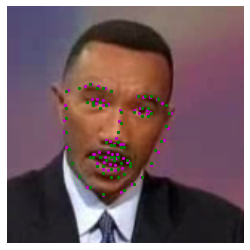

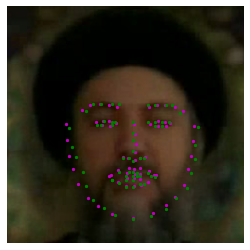

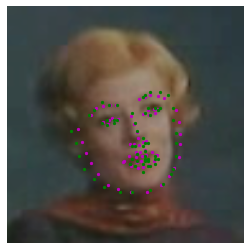

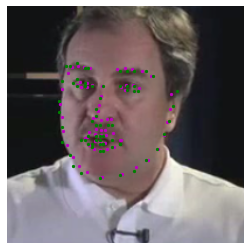

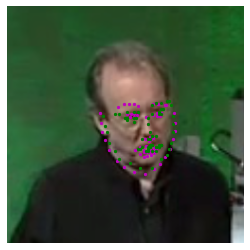

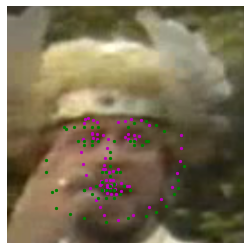

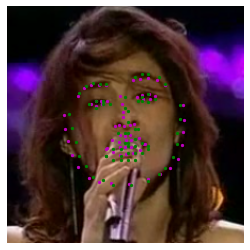

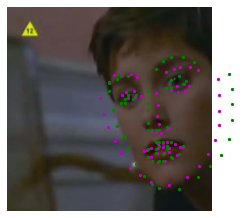

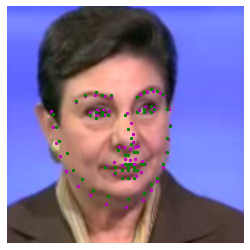

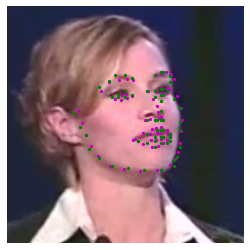

In [ ]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image'].to(device)
        key_pts = sample['keypoints'].to(device)

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor).to(device)

        # forward pass to get net output
        facial_net.eval()
        output_pts = facial_net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    image = (image * std )+mean
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')
        
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(50,20))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.to('cpu').detach().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        print(test_outputs.shape)
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.to('cpu').detach().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts.to('cpu').detach())
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [ ]:
class RMSLoss(nn.Module):
    def __init__(self):
        super(RMSLoss , self).__init__()
        self.criterion = nn.MSELoss()
        
    def forward(self , y_pred , y_true):
        
        loss = torch.sqrt(self.criterion(y_pred , y_true))
        
        return loss

In [ ]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion =  nn.SmoothL1Loss(reduction='sum')

optimizer = optim.Adam(facial_net.parameters() , lr= 0.001 , weight_decay=0.1)

In [ ]:
def train_net(n_epochs):

    # prepare the net for training
    facial_net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)

            # forward pass to get outputs
            output_pts = facial_net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')

In [ ]:

# train your network
n_epochs = 50 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

In [ ]:
torch.save(facial_net.state_dict(),"facial_net.pth")

# Visualize the mesh
![](https://miro.medium.com/max/1536/1*mArsPXT2PB19dF4sPR-VSA.jpeg)

In [ ]:
#keep the index ranges for the better visualization
key_pairs={
"face_boarder" : [(1,2),(2,3) ,(3,4) ,(4,5) ,(5,6) ,(6,7) ,(7,8) ,(8,9) ,(9,10) ,(10,11) ,(11,12) ,(12,13) ,(13,14) ,(14,15) ,(15,16) , [16,17]],
"upper_lips" : [(49,50) , (50,51),(51,52),(52,53),(53,54),(54,55),(49,61),(61,62),(62,63),(63,64),(64,65),(65,55)] ,
"lower_lips" : [ (49,60) , (60,59) , (59,58) , (58,57) , (57,56) , (56,55) , (49,61) , (61,68) , (68,67) ,(67,66) , (66,65) , (65,55) ],
"left_eye_upper":[(18,19),(19,20),(20,21),(21,22)],
"right_eye_upper" :[(23,24),(24,25),(25,26),(26,27)],
"left_eye" :[(37,38),(38,39),(39,40),(40,41),(41,42),(42,37)],
"right_eye" :[(43,44),(44,45),(45,46),(46,47),(47,48),(48,43) ],
"nose_upper" :[(28,29),(29,30),(30,31)],
"nose_down" :[(32,33),(33,34),(34,35),(35,36)]
}

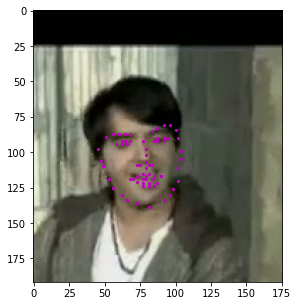

In [ ]:
import cv2
# select an image by index in our data frame
n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].to_numpy()
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
image = cv2.imread(os.path.join('../input/facialkeypoint/training/', image_name))
image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
show_keypoints(image, key_pts)
plt.show()

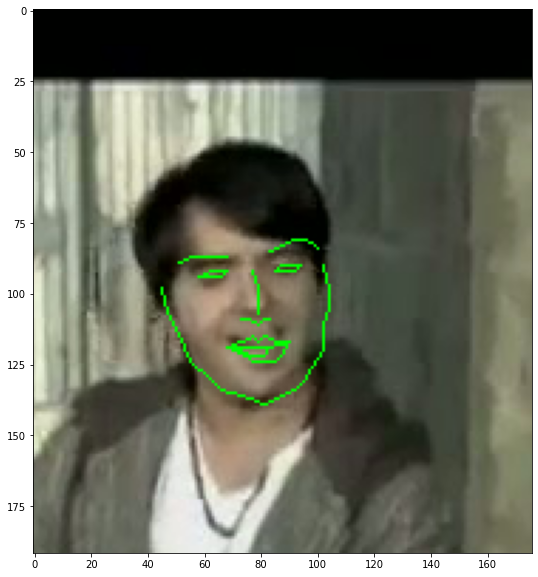

In [ ]:
import numpy as np
fig = plt.figure(figsize=(20,10))
for index, item in enumerate(key_pairs.items()): 
    for data in item[1] :
        p1 = key_pts[data[0]-1].astype(int)
        p2 = key_pts[data[1]-1].astype(int)
       
        cv2.line(image, tuple(p1), tuple(p2), [0, 255, 0], 1) 
plt.imshow(image)

<Figure size 3600x1440 with 0 Axes>

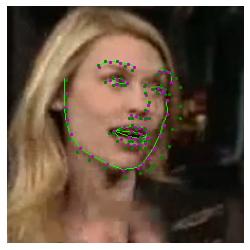

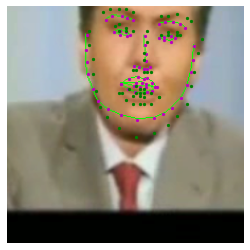

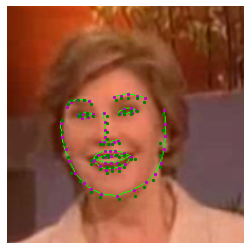

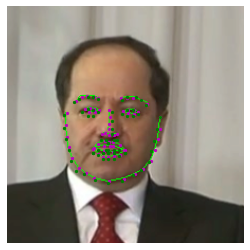

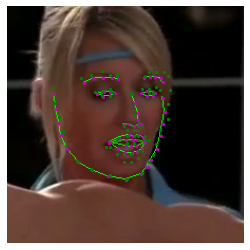

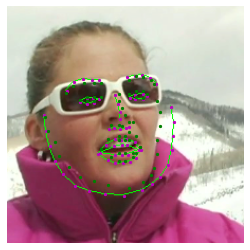

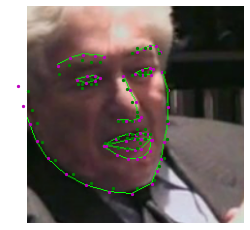

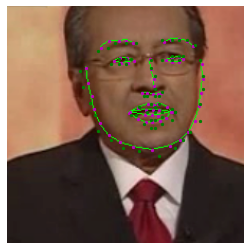

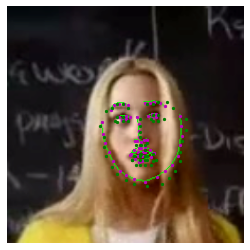

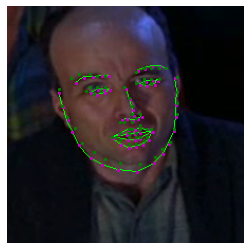

In [ ]:
fig = plt.figure(figsize=(50,20))
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(50,20))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.to('cpu').detach().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.to('cpu').detach().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts.to('cpu').detach())
            
        plt.axis('off')
    plt.show()
    
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    image = (image * std )+mean
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    image = np.uint8(image*255.0)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')
    for index, item in enumerate(key_pairs.items()): 
        for data in item[1] :
            p1 = predicted_key_pts[data[0]-1].astype(int)
            p2 = predicted_key_pts[data[1]-1].astype(int)
            cv2.line(image, tuple(p1), tuple(p2), [0, 255, 0], 1) 
    plt.imshow(image)
        
test_images, test_outputs, gt_pts = net_sample_output()

visualize_output(test_images, test_outputs, gt_pts)